## Q1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def simulate_lif_model(duration,delta_t=0.001,input_current=None,rng=None, seed=1234,**parameters):
    '''Simulate integrate-and-fire model

    Parameters
    ----------
    duration :      Time duration to simulate the dynamics for
    input_current : Stimulus input current
    delta_t :       Simulation time-step size (time between frames)
    rng :           Random number generator
    seed :          Seed to use if rng not supplied
    parameters :    Other model paramters

    Returns
    -------
    membrane_potential : Membrane potential trace
    spike_train :        Spike train (frame-based)
    input_current :      Input current used
    '''
    # Parameters for simulation
    default_parameters = {
        'resting_potential':          -70, # (mV)
        'reset_potential':            -80, # (mV)
        'noise_amplitude':           0.03, # (mA s^{-1/2})
        'input_resistance':            50, # (ohm)
        'background_current':         0.1, # (mA)
        'firing_threshold':           -50, # (mV)
        'membrane_time_constant':    0.02, # (s)
        'initial_membrane_potential': -70, # (mV)
    }
    for p in parameters:
        if not p in default_parameters:
            raise TypeError(f'Unknown parameter: {p}')
    parameters = default_parameters|parameters

    frame_times = np.arange(0,duration,delta_t)
    if rng is None: rng = np.random.default_rng(seed)
    if input_current is None:
        input_current = parameters['noise_amplitude']*rng.normal(size=len(frame_times))
    membrane_potential = parameters['initial_membrane_potential']
    membrane_potential_trace = []  # Trace of membrane potential
    spike_train = []  # spike train
    for i,time in enumerate(frame_times):
        total_input = input_current[i]/np.sqrt(delta_t)+parameters['background_current']
        membrane_potential += delta_t*(
            parameters['resting_potential']
            -membrane_potential
            +total_input*parameters['input_resistance']
        )/parameters['membrane_time_constant']
        membrane_potential_trace.append(membrane_potential)
        if membrane_potential>parameters['firing_threshold']:
            membrane_potential = parameters['reset_potential']
            spike_train.append(1)
        else: spike_train.append(0)
    return np.array(membrane_potential_trace),np.array(spike_train),input_current

(-0.5, 0.1)

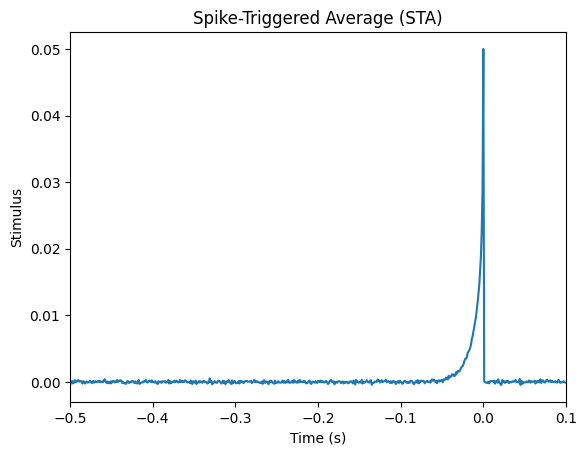

In [3]:
# Step 1. 產生 LIF spike train（白噪音輸入）
potentials,spike_train,inputs = simulate_lif_model(duration=10000,seed=1234,noise_amplitude=(sigma:=.03))
delta_t=0.001
# Step 2. 定義 STA 的時間範圍
win_range = np.array([-0.5, 0.1])
win_times = np.arange(*win_range, delta_t)

# Step 3. 計算 STA
sta = np.mean([
    inputs[i + int(win_range[0]/delta_t): i + int(win_range[1]/delta_t)]
    for i in np.where(spike_train)[0]
    if i + int(win_range[0]/delta_t) >= 0 and i + int(win_range[1]/delta_t) < len(inputs)
], axis=0)

# Step 4. 畫出結果
plt.plot(win_times, sta)
plt.title("Spike-Triggered Average (STA)")
plt.xlabel("Time (s)")
plt.ylabel("Stimulus")
plt.xlim(-0.5,0.1)

## Q2

In [4]:
sigma = .03
rng = np.random.default_rng(1234)
inputs = sigma*rng.normal(size=int(10/delta_t))
times = np.arange(len(inputs))*delta_t

In [5]:
mix_times = np.arange(-.5,.5,delta_t)
mix_weights = np.exp(-(mix_times/0.1)**2)
mix_weights /= (delta_t*mix_weights.sum())

In [6]:
front_drop = (mix_times<0).sum()
# Filter the stimulus, making it smoother
inputs_alt = np.convolve(inputs-inputs.mean(),mix_weights)[front_drop:front_drop-len(mix_times)+1]
# Preserve mean and standard deviation
inputs_alt = (inputs_alt-inputs_alt.mean())*inputs.std()/inputs_alt.std()+inputs.mean()

(0.0, 10.0)

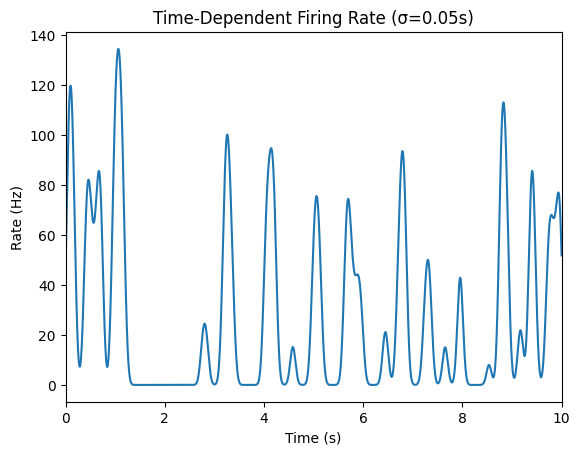

In [7]:
# Step 1. 使用新刺激
duration = 10.0
potentials_new, spike_train_new, inputs_2 = simulate_lif_model(duration=duration, input_current=inputs_alt)

# Step 2. 用 Gaussian window 平滑
sigma = 0.05
win_size = int(6 * sigma / delta_t)
win = np.exp(-0.5 * (np.arange(-win_size, win_size) * delta_t / sigma) ** 2)
win /= win.sum()

# Step 3. 計算 firing rate（以秒為單位）
firing_rate = np.convolve(spike_train_new / delta_t, win, mode='same')

plt.plot(times, firing_rate)
plt.title("Time-Dependent Firing Rate (σ=0.05s)")
plt.xlabel("Time (s)")
plt.ylabel("Rate (Hz)")
plt.xlim(0, 10)

(0.0, 10.0)

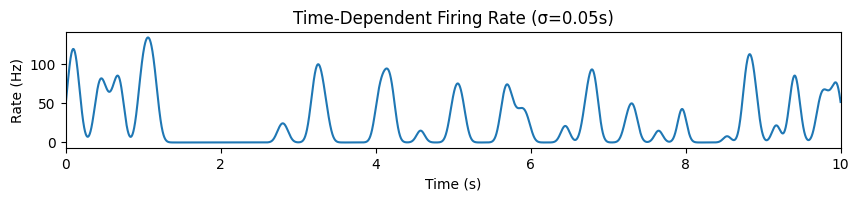

In [26]:
# Step 1. 使用新刺激
duration = 10.0
potentials_new, spike_train_new, inputs_2 = simulate_lif_model(duration=duration, seed=123, input_current=inputs_alt)

# Step 2. 用 Gaussian window 平滑
sigma = 0.05
win_size = int(6 * sigma / delta_t)
win = np.exp(-0.5 * (np.arange(-win_size, win_size) * delta_t / sigma) ** 2)
win /= win.sum()

# Step 3. 計算 firing rate（以秒為單位）
firing_rate = np.convolve(spike_train_new / delta_t, win, mode='same')

plt.figure(figsize=(10,1.5))
plt.plot(times, firing_rate)
plt.title("Time-Dependent Firing Rate (σ=0.05s)")
plt.xlabel("Time (s)")
plt.ylabel("Rate (Hz)")
plt.xlim(0, 10)

#### Question: If you supply a diﬀerent seed to the simulate_lif_model(), will you get a diﬀerent spike train?

No, the result will be the same.

## Q3

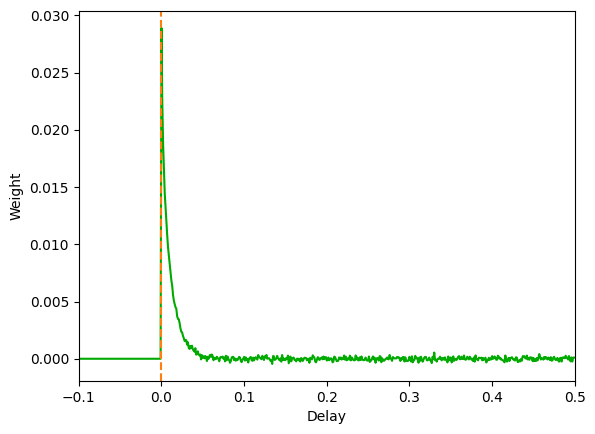

In [16]:
win_range = np.array([-0.1,0.5]) # Kernel time range
win_times = np.arange(*win_range,delta_t) # Kernel time frames
# Make up a nontrivil kernel
win_kernel = sta[::-1]
win_kernel *= (win_times>0)  # Make negative delay part zero (causal)
#win_kernel /= max(win_kernel) # Normalize max to 1

plt.plot(win_times,win_kernel,color='#0a0')
plt.xlim(win_range)
plt.axvline(0,ls='--',color='C1')
plt.ylabel('Weight')
plt.xlabel('Delay')
plt.show()

In [18]:
def relu_func(x,m):
    return m*x*(x>0)

In [19]:
from scipy.optimize import curve_fit

front_drop = (win_times<0).sum() # Number of frames to drop in front

sta_convolve = np.convolve(inputs_2, win_kernel)[front_drop:front_drop-len(sta)+1]

relu_para,_ = curve_fit(relu_func,sta_convolve,firing_rate)

#mu_values = relu_func(, scale)

In [21]:
print(relu_para)

[8372.64608886]


## Q4

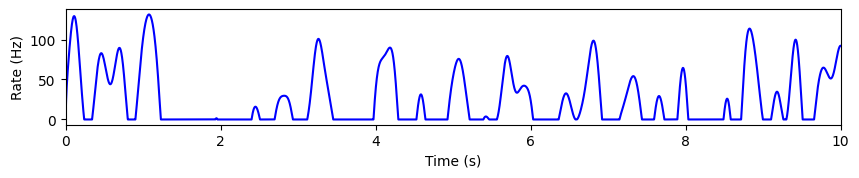

In [29]:
firing_rates_2 = relu_func(np.convolve(inputs_2,win_kernel)[front_drop:front_drop-len(win_kernel)+1], relu_para)

plt.figure(figsize=(10,1.5))
plt.xlabel("Time (s)")
plt.ylabel("Rate (Hz)")
plt.plot(times,firing_rates_2,color='#00f')
plt.xlim(0,10)
plt.show()

In [28]:
def gen_spikes(r,dt,rng=None,seed=123):
    '''Generate spike train from Poisson rate

    Parameters
    ----------
    r:  Array of spike rates
    dt: Time step size

    Returns
    -------
    Event-based spike train
    '''
    if rng is None: rng = np.random.default_rng(seed)
    i = 0
    s = 0
    spks = []
    while True:
        s += rng.exponential() # Area to advance for next spike
        while s>r[i]*dt: # Advance to next frame if enough area
            s -= r[i]*dt
            i += 1
            if i>=len(r): break # No more frame
        else:
            spks.append(i*dt+s/r[i]) # Spike time in this frame
            continue
        break
    return np.array(spks)

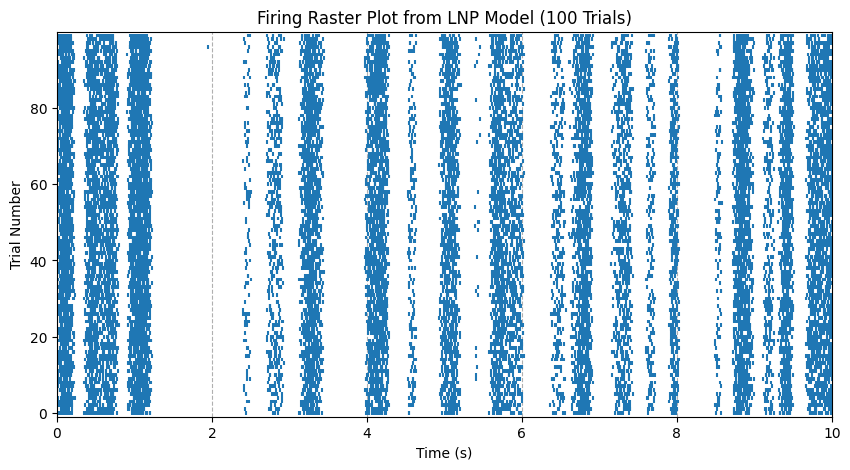

In [35]:
num_trials = 100
all_spike_events = [] # Store list of spike times for each trial

for trial in range(num_trials):
    spike_times_events = gen_spikes(firing_rates_2, delta_t,seed=trial + 200) # Use a fresh seed set
    all_spike_events.append(spike_times_events)

plt.figure(figsize=(10, 5))
for trial, events in enumerate(all_spike_events):
    plt.eventplot(events, lineoffsets=trial, linelengths=1)

plt.title(f'Firing Raster Plot from LNP Model (100 Trials)')
plt.xlabel('Time (s)')
plt.ylabel('Trial Number')
plt.yticks(np.arange(0, num_trials, 20))
plt.xlim(0, 10)
plt.ylim(-1, num_trials)
plt.grid(axis='x', linestyle='--')
plt.show()
